Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Imports:

In [32]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Tour creation and initial population:

In [33]:
# computes the total distance of a tour, including the return to the first city
def tour_length (tour, dist_matrix):
    tour = np.array(tour)
    return dist_matrix[tour, np.roll(tour, -1)].sum()

# generates a random permutation of cities -> a random tour
def random_tour (n):
    tour = list (range(n))
    random.shuffle(tour)
    return tour

# creates an initial population of random tours
def initial_population (pop_size, n):
    return [random_tour (n) for _ in range (pop_size)]

# generates a tour using the nearest neighbor heuristic -> a greedy tour
def greedy_tour (n, distance_matrix, start_city):
    not_visited = list (range(n))
    tour = [start_city]
    not_visited.remove(start_city)
    while not_visited:
        last = tour[-1]
        next_city = min (not_visited, key=lambda city: distance_matrix[last, city])
        tour.append(next_city)
        not_visited.remove(next_city)
    return tour

# creates an initial population of greedy tours + random tours
def greedy_population (n, dist_matrix, pop_size):
    population = []
    # 50% are greedy tours:
    for start_city in range(min(pop_size // 2, n)):
        tour = greedy_tour(n, dist_matrix, start_city)
        population.append(tour)
    # the remaining 50% are random tours: 
    while len (population) < pop_size:
        tour = list (range(n))
        random.shuffle(tour)
        population.append(tour)
    return population

# Selection functions:

In [34]:
# selection of 1 tour using tournament selection (tournament among k=3 tours)
# fitnesses are tour lengths
def tournament_selection (pop, fitnesses, k=3):
    selected = random.sample (list(zip(pop, fitnesses)), k)
    selected.sort(key=lambda x: x[1])
    return selected[0][0]

# Crossover functions:

In [35]:
# performs order crossover (OX)
def ordered_crossover (parent1, parent2):
    n = len (parent1)
    start, end = sorted (random.sample(range(n), 2))
    child = [None] * n
    child[start:end] = parent1[start:end]
    taken = set (child[start:end])
    fill_values = [x for x in parent2 if x not in taken]
    fill_index = [i for i in range(n) if child[i] is None]
    for i, val in zip (fill_index, fill_values):
        child[i] = val
    return child

# performs inver-over crossover
# there's also a probability p of choosing a random city instead of following parent2
# written with the help of ChatGPT
def inver_over_crossover (parent1, parent2, p=0.5):
    child = parent1.copy()
    n = len (child)
    for _ in range (n):
        c = random.choice(child)                                        #random starting city
        while True:
            if random.random() < p:
                c_prime = random.choice([x for x in child if x != c])   #random city (not c)
            else:
                idx = parent2.index(c)
                c_prime = parent2[(idx + 1) % n]                        #successor of c in parent2
            i, j = child.index(c), child.index(c_prime)                 #indices of c and c_prime in child
            if abs (i - j) == 1 or abs (i - j) == n - 1:                #stop if _prime is adjacent to c
                break
            #invert the segment between them
            if i < j:
                child[i+1:j+1] = reversed (child[i+1:j+1])
            else:
                child[j+1:i+1] = reversed (child[j+1:i+1])
            c = c_prime                                                 #continue from new c
    return child

# performs a faster version of inner-over crossover
# uses an index map for O(1) lookups, limits one inversion per city
# written with the help of ChatGPT
def inver_over_crossover_fast (parent1, parent2, p=0.5):
    child = parent1.copy()
    n = len (child)
    pos = {city: idx for idx, city in enumerate(child)}                 #precompute a position map for O(1) access
    for _ in range (n):
        c = random.choice(child)
        # choose c' (one inversion per city max):
        if random.random() < p:
            c_prime = random.choice([x for x in child if x != c])
        else:
            idx = parent2.index(c)
            c_prime = parent2[(idx + 1) % n]
        i, j = pos[c], pos[c_prime]
        if abs (i - j) == 1 or abs (i - j) == n - 1:                      #stop if adjacent (including wraparound)
            continue
        #inversion:
        if i < j:
            child[i+1:j+1] = reversed(child[i+1:j+1])
            #update positions for affected elements
            for k in range(i+1, j+1):
                pos[child[k]] = k
        else:
            child[j+1:i+1] = reversed(child[j+1:i+1])
            for k in range(j+1, i+1):
                pos[child[k]] = k
    return child

# Mutation functions:

In [36]:
# randomly swaps 2 cities (with a given mutation rate)
def swap_mutation (tour, mutation_rate=0.05):
    new_tour = tour.copy()
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(tour)), 2)
        new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

# reverser a random segment of the tour (with a given mutation rate)
def inversion_mutation (tour, mutation_rate=0.05):
    if random.random() < mutation_rate:
        a, b = sorted(random.sample(range(len(tour)), 2))
        tour[a:b+1] = reversed(tour[a:b+1])
    return tour

# removes 1 city and inserts it at another random position (with a given mutation rate)
def insert_mutation(tour , mutation_rate=0.05):
    if random.random() < mutation_rate:
        a, b = random.sample(range(len(tour)), 2)
        city = tour.pop(a)
        tour.insert(b, city)
    return tour

# Genetic algorithm:

In [37]:
def genetic_tsp (distance_matrix, pop_size=100, generations=500, base_mutation_rate=0.15):
    n = distance_matrix.shape[0]
    population = greedy_population(n, distance_matrix, pop_size)
    mutation_rate = base_mutation_rate

    best_distances = [] 
    start_time = time.time()

    for gen in range (generations):
        fitnesses = [tour_length(t, distance_matrix) for t in population]
        best_idx = np.argmin(fitnesses)

        best_distances.append(fitnesses[best_idx])

        # --- Adaptive elitism ---
        elite_frac = 0.02 + 0.03 * (gen / generations)   # grows from 2% → 5%
        elite_count = max (1, int(elite_frac * pop_size))
        elite_indices = np.argsort(fitnesses)[:elite_count]
        elites = [population[i] for i in elite_indices]
        
        new_population = elites.copy()

        while len (new_population) < pop_size:
            parent1 = tournament_selection (population, fitnesses)
            parent2 = tournament_selection (population, fitnesses)
            child = ordered_crossover (parent1, parent2)
            child = inversion_mutation (child, mutation_rate)
            new_population.append(child)
        
        population = new_population
    
    # Final best
    final_fitnesses = [tour_length(t, distance_matrix) for t in population]
    best_idx = np.argmin(final_fitnesses)
    best_tour = population[best_idx]
    
    best_distance = final_fitnesses[best_idx]
    total_time = time.time() - start_time
    print(f"- Best distance: {best_distance:.2f}")
    print(f"- Time taken: {total_time:.2f} s")
    
    plt.figure()
    plt.plot(best_distances, label="Best Distance")
    plt.title("Best Distance over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Best Distance")
    plt.grid(True)
    plt.legend()
    plt.show()

    print("-" * 60)

    return best_tour, final_fitnesses[best_idx]


# Problems to test:


<< Running Genetic TSP for problem_g_10 >>
- Best distance: 1497.66
- Time taken: 6.07 s


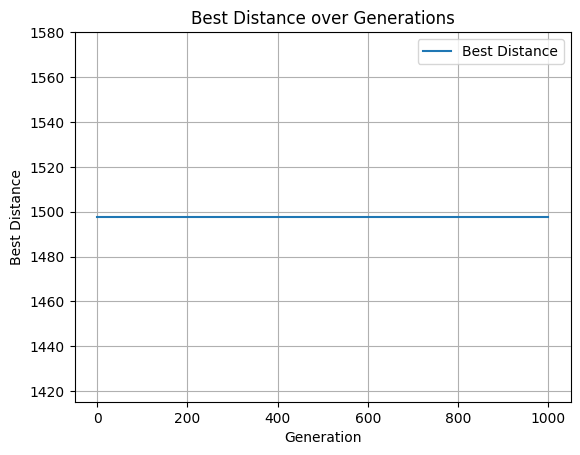

------------------------------------------------------------

<< Running Genetic TSP for problem_g_20 >>
- Best distance: 1755.51
- Time taken: 6.35 s


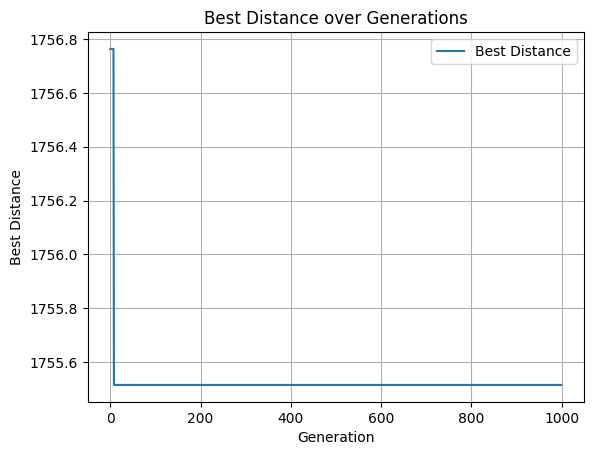

------------------------------------------------------------

<< Running Genetic TSP for problem_g_50 >>
- Best distance: 2677.21
- Time taken: 7.10 s


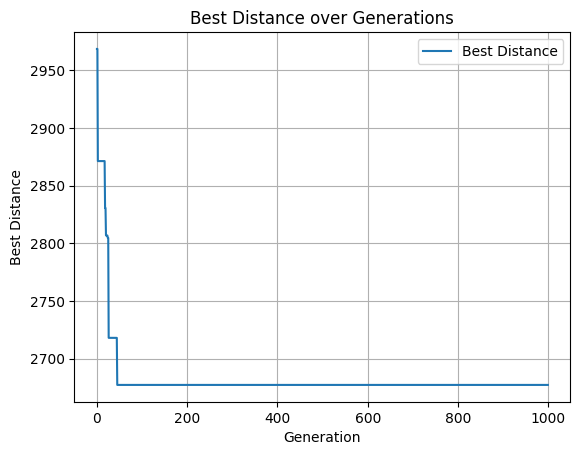

------------------------------------------------------------

<< Running Genetic TSP for problem_g_100 >>
- Best distance: 4136.06
- Time taken: 8.39 s


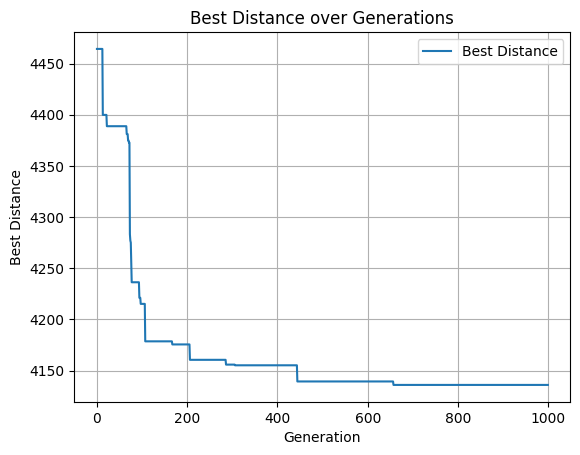

------------------------------------------------------------

<< Running Genetic TSP for problem_g_200 >>
- Best distance: 5752.18
- Time taken: 11.01 s


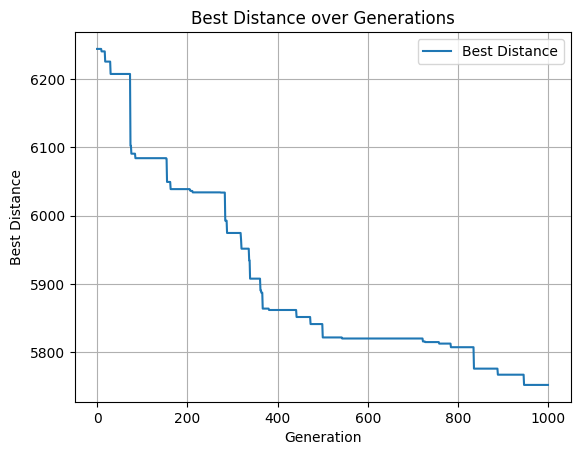

------------------------------------------------------------

<< Running Genetic TSP for problem_g_500 >>
- Best distance: 9166.13
- Time taken: 18.52 s


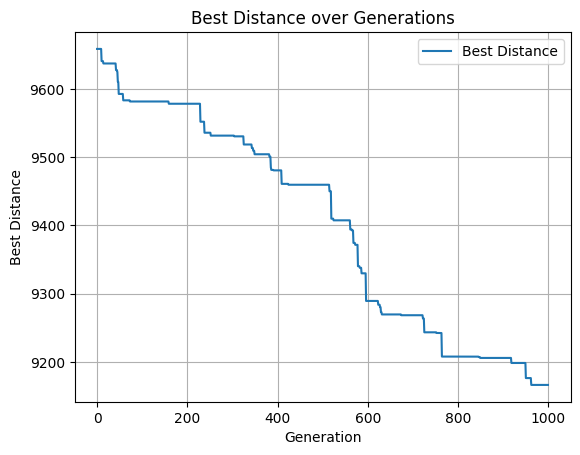

------------------------------------------------------------

<< Running Genetic TSP for problem_g_1000 >>
- Best distance: 13731.26
- Time taken: 31.40 s


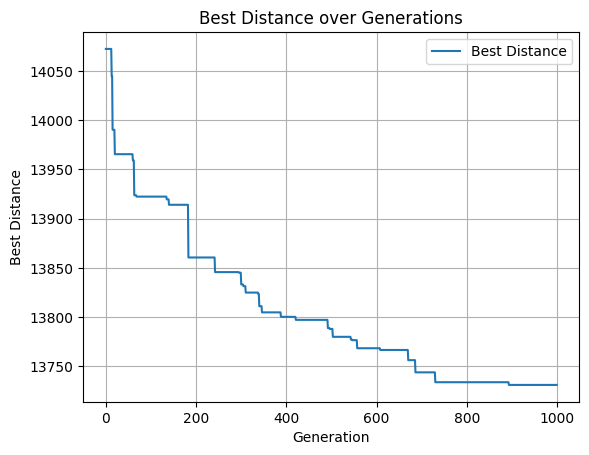

------------------------------------------------------------

<< Running Genetic TSP for problem_r1_10 >>
- Best distance: 184.27
- Time taken: 6.28 s


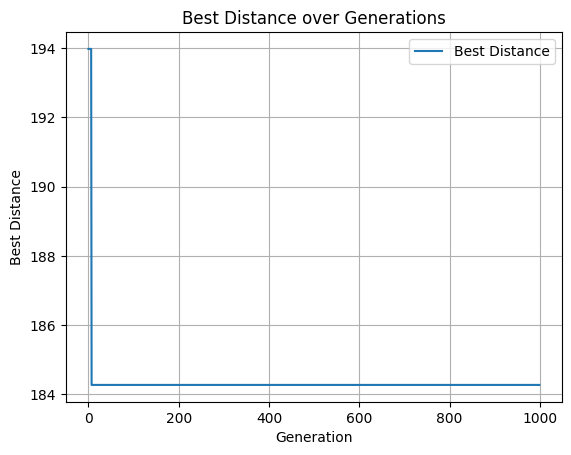

------------------------------------------------------------

<< Running Genetic TSP for problem_r1_20 >>
- Best distance: 340.86
- Time taken: 6.62 s


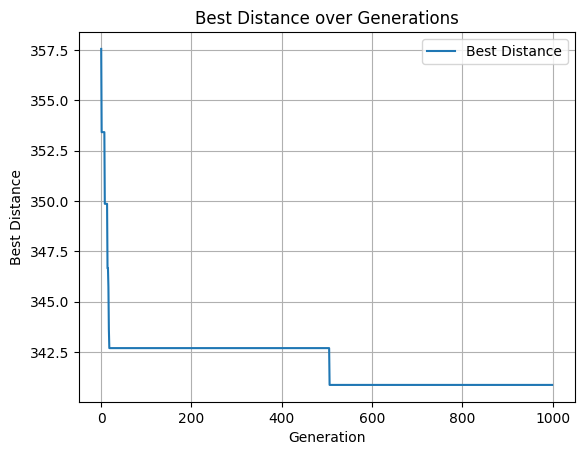

------------------------------------------------------------

<< Running Genetic TSP for problem_r1_50 >>
- Best distance: 574.42
- Time taken: 7.61 s


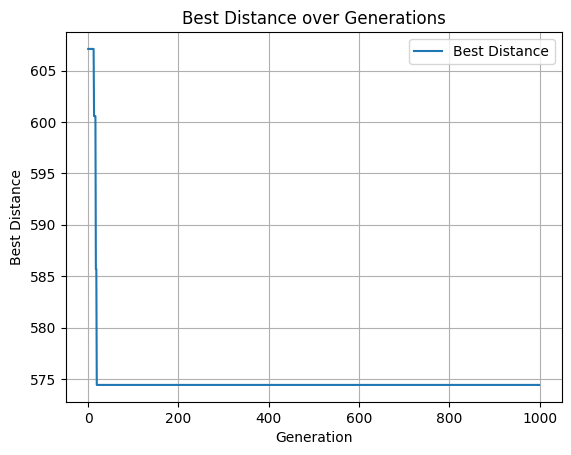

------------------------------------------------------------

<< Running Genetic TSP for problem_r1_100 >>
- Best distance: 738.81
- Time taken: 8.92 s


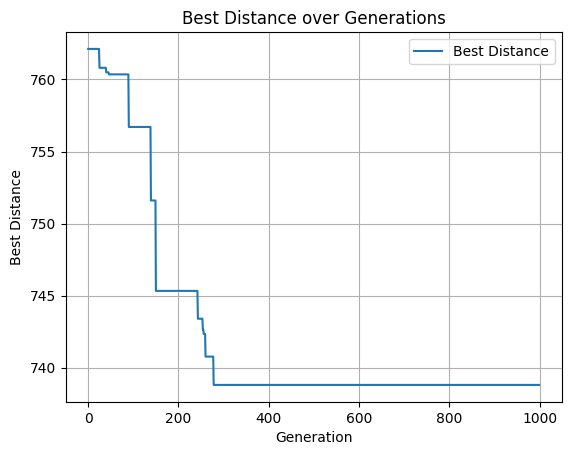

------------------------------------------------------------

<< Running Genetic TSP for problem_r1_200 >>
- Best distance: 1116.04
- Time taken: 11.67 s


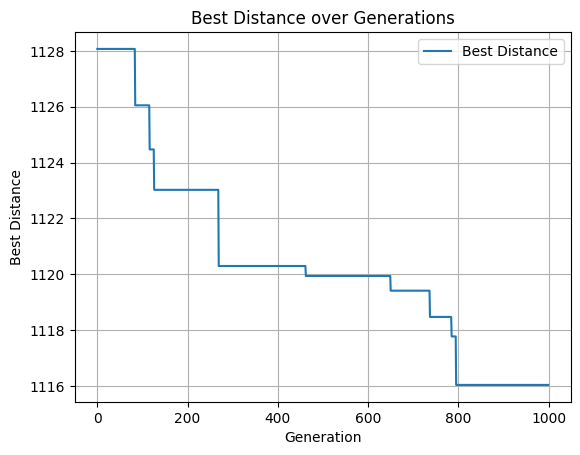

------------------------------------------------------------

<< Running Genetic TSP for problem_r1_500 >>
- Best distance: 1754.14
- Time taken: 19.76 s


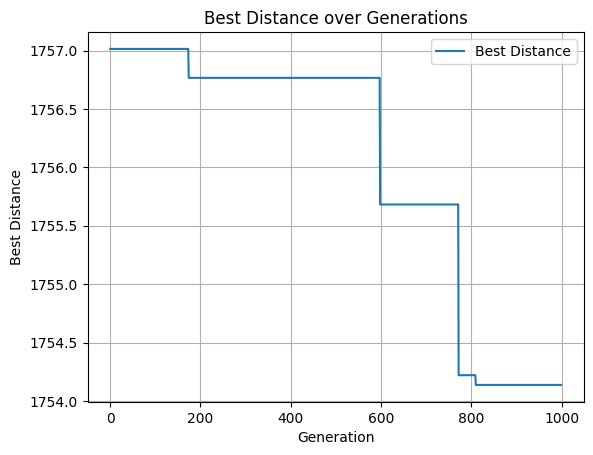

------------------------------------------------------------

<< Running Genetic TSP for problem_r1_1000 >>
- Best distance: 2542.70
- Time taken: 35.30 s


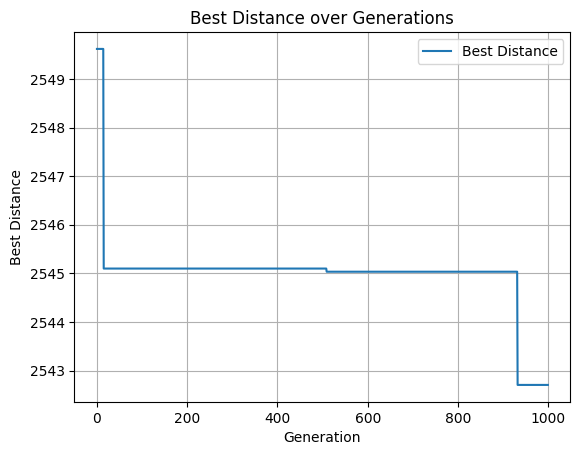

------------------------------------------------------------

<< Running Genetic TSP for problem_r2_10 >>
- Best distance: -411.70
- Time taken: 7.22 s


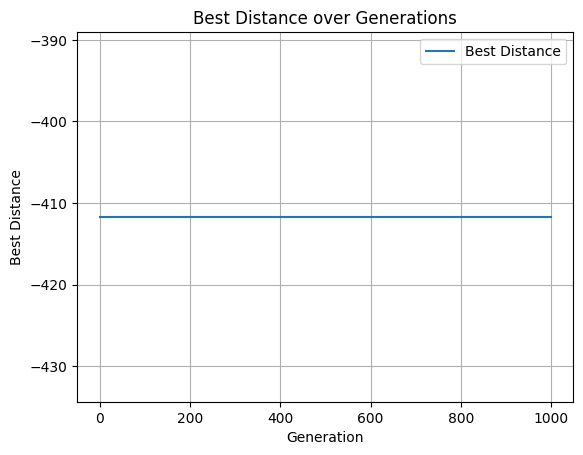

------------------------------------------------------------

<< Running Genetic TSP for problem_r2_20 >>
- Best distance: -796.86
- Time taken: 7.37 s


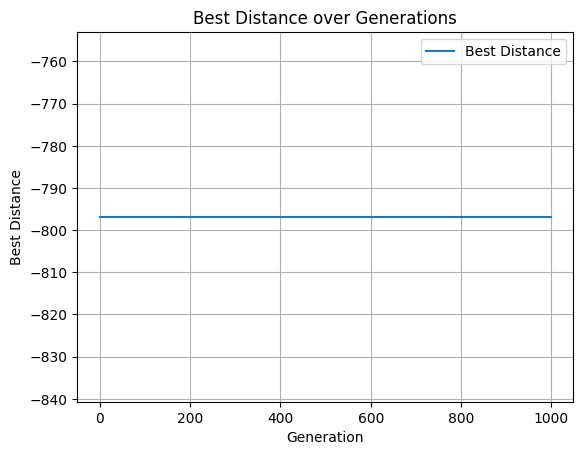

------------------------------------------------------------

<< Running Genetic TSP for problem_r2_50 >>
- Best distance: -2232.38
- Time taken: 8.20 s


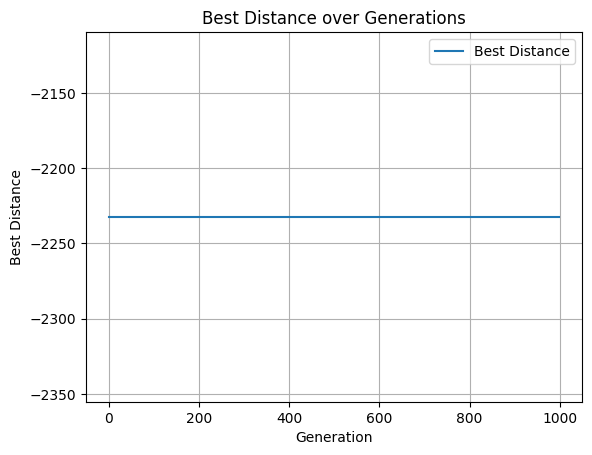

------------------------------------------------------------

<< Running Genetic TSP for problem_r2_100 >>
- Best distance: -4667.68
- Time taken: 9.66 s


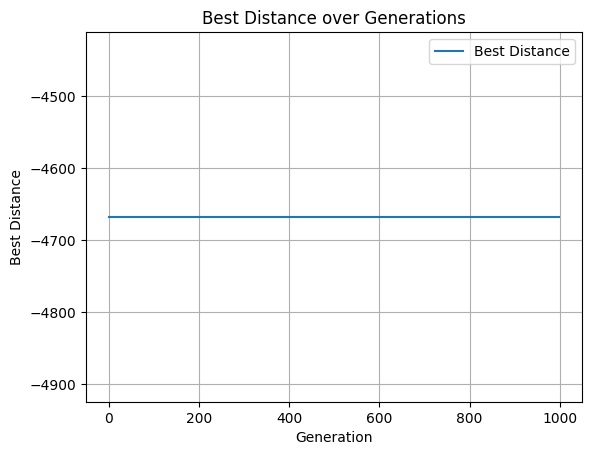

------------------------------------------------------------

<< Running Genetic TSP for problem_r2_200 >>
- Best distance: -9603.77
- Time taken: 12.28 s


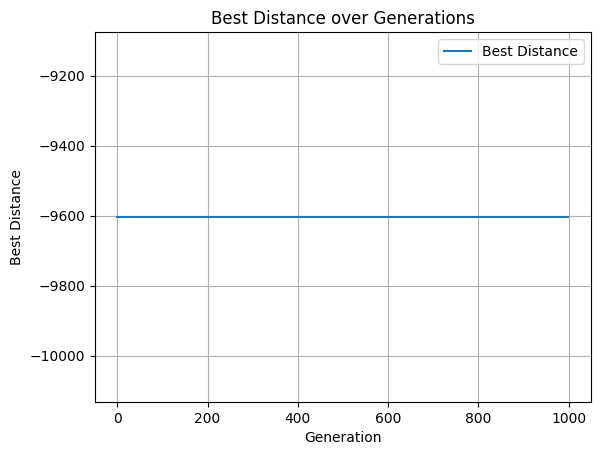

------------------------------------------------------------

<< Running Genetic TSP for problem_r2_500 >>
- Best distance: -24529.66
- Time taken: 19.96 s


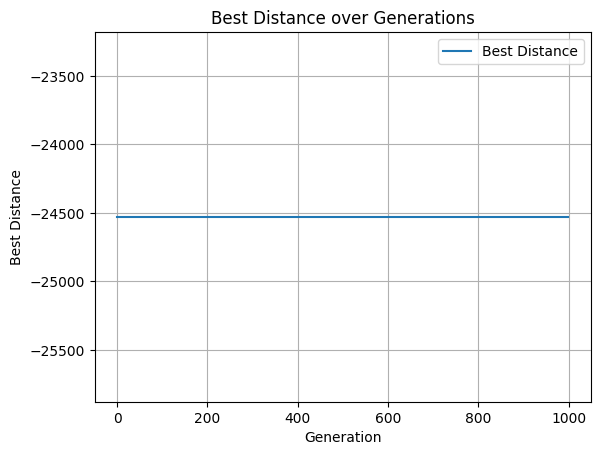

------------------------------------------------------------

<< Running Genetic TSP for problem_r2_1000 >>
- Best distance: -49402.98
- Time taken: 33.31 s


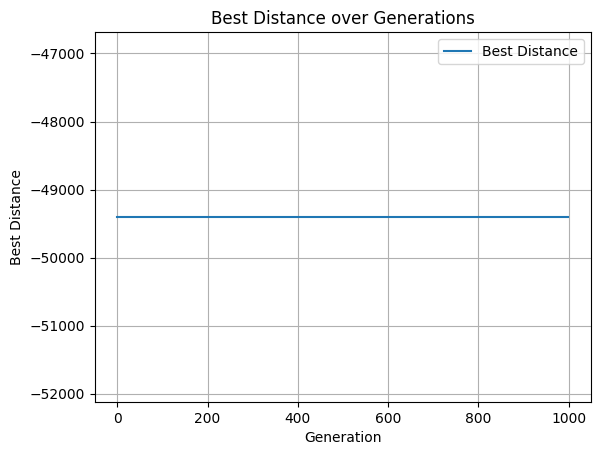

------------------------------------------------------------


In [38]:
sizes = [10, 20, 50, 100, 200, 500, 1000]
letters = [ 'g', 'r1', 'r2']

for letter in letters:
    for X in sizes:
        filename = f"lab2/problem_{letter}_{X}.npy"
        print(f"\n<< Running Genetic TSP for problem_{letter}_{X} >>")
        
        problem = np.load(filename)
        
        start_time = time.time()
        best_tour, best_dist = genetic_tsp(problem, pop_size=200, generations=1000, base_mutation_rate=0.15)
        elapsed = time.time() - start_time
